# Ramp-Up Notebook

Dear newcomer,

The following notebook has been included in the NeuorMorphic repository to assist you in ramping up and building intuition surrounding the computational neuron models you will be using.

I appreciate that it can be difficult inheriting someone else's project, escpecially one so complex, so please reach out to me if clarification is required - I will update the repository in light of any improvements that may be necessary.

Enjoy!


## **Hodgkin Huxley Membrane**

This section implements the Hodgkin Huxley conductance-based neuron model. It is important to have some intuition regarding this foundational model, as its underpinning biophysics can also relate somehwat to the MQIF neuron models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


### α and β functions

Below are the code and plots for the α and β functions. These describe the rates of opening/closing for each channel, which is important for the ODE's governing the proportion of open ion channels.

In [2]:
# α and β functions
# These describe the rates of ion channel gating as a function of voltage.

def alpha_m(V):
    am = (2.5 - 0.1 * V) / (np.exp(2.5 - 0.1 * V) - 1)
    return am

def beta_m(V):
    bm = 4 * np.exp(-V / 18)
    return bm

def alpha_h(V):
    ah = 0.07 * np.exp(-V / 20)
    return ah

def beta_h(V):
    bh = 1 / (np.exp(3.0 - 0.1 * V) + 1)
    return bh

def alpha_n(V):
    an = (0.1 - 0.01 * V) / (np.exp(1 - 0.1 * V) - 1)
    return an

def beta_n(V):
    bn = 0.125 * np.exp(-V / 80)
    return bn

Text(0.5, 1.0, 'Beta_n')

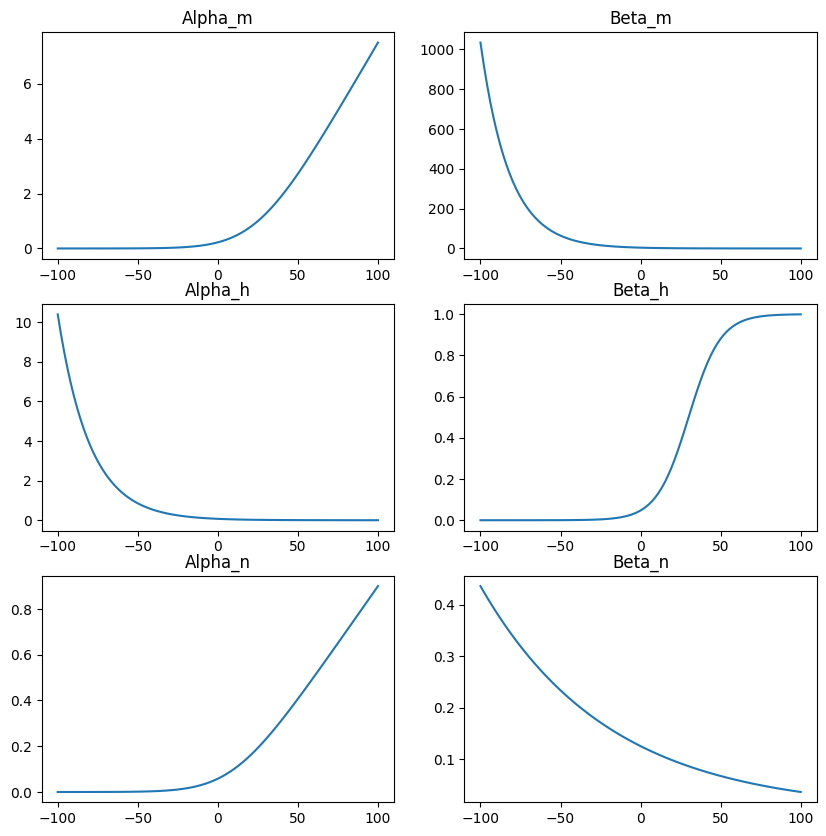

In [3]:
# Visualisation of these functions
V_array = np.linspace(-100, 100, 100)

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

am_Array = [alpha_m(V) for V in V_array]
bm_Array = [beta_m(V) for V in V_array]
ah_Array = [alpha_h(V) for V in V_array]
bh_Array = [beta_h(V) for V in V_array]
an_Array = [alpha_n(V) for V in V_array]
bn_Array = [beta_n(V) for V in V_array]

m_inf = [alpha_m(V)/(alpha_m(V)+beta_m(V)) for V in V_array]

# Plot on each subplot
axes[0, 0].plot(V_array, am_Array)
axes[0, 0].set_title('Alpha_m')

axes[0, 1].plot(V_array, bm_Array)
axes[0, 1].set_title('Beta_m')

axes[1, 0].plot(V_array, ah_Array)
axes[1, 0].set_title('Alpha_h')

axes[1, 1].plot(V_array, bh_Array)
axes[1, 1].set_title('Beta_h')

axes[2, 0].plot(V_array, an_Array)
axes[2, 0].set_title('Alpha_n')

axes[2, 1].plot(V_array, bn_Array)
axes[2, 1].set_title('Beta_n')


### ODE's - Hodgkin Huxley

Coded below are the differential equations governing the Hodgkin Huxley model of action potentials. These are integrated using forward Euler integration with a time step of 0.001 ms.

The variables m, n , and h are variables that directly influence the membrane ionic currents. The combined action of m and h control Na+ channels. n controls K+ channels. They denote the proportion of open ion channels. v is the membrane potential.

As membrane potential increases, an electric field is induced between the cell and extracellular fluid. This causes a movement of ions, as described by these ODE's.

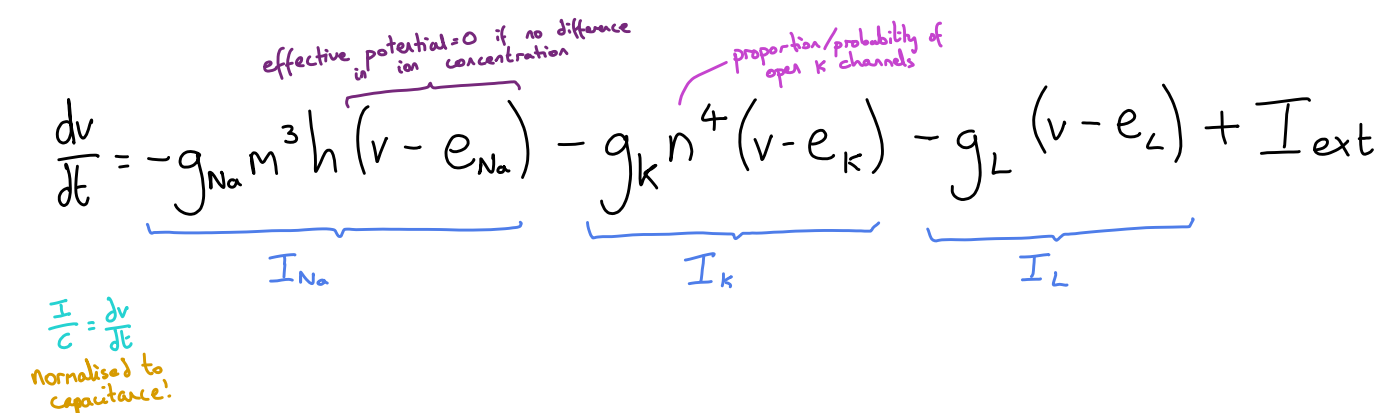

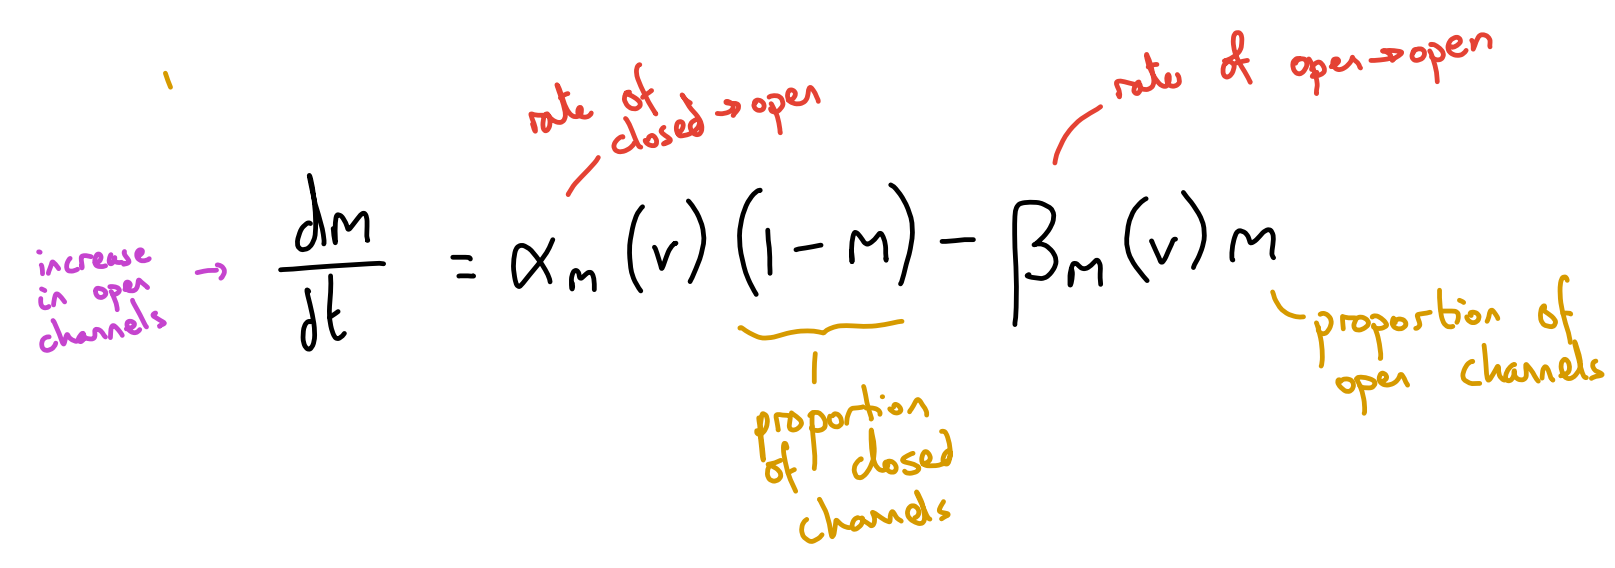

In [4]:
# ODEs to integrate
def m_dot(V_in, m):
    return alpha_m(V_in)*(1-m) - beta_m(V_in)*m

def h_dot(V_in, h):
    return alpha_h(V_in)*(1-h) - beta_h(V_in)*h

def n_dot(V_in, n):
    return alpha_n(V_in)*(1-n) - beta_n(V_in)*n 

# Membrane Potential
def v_dot(m, h, n, v, I_ext,
          g_Na = 120.0, e_Na = 115.0,   # Sodium conductance densities
          g_K = 36.0, e_K = -12.0,      # Potassium
          g_L = 0.3, e_L = 10.6):       # Leakage

      return -(g_Na * m**3 * h * (v-e_Na)) - (g_K * n**4 * (v-e_K)) - (g_L * (v-e_L)) + I_ext

### Forwards Euler Integration

The following function simulates the dynamics of the membrane potential and the three state valiables using forwards Euler integration.

In [5]:
# Integrating function
  # m0, h0, n0 ,v0 ~ initial values
  # I_ext ~ input current waveform

def simulate(num_steps, m0, h0, n0, v0, I_ext):

  # Initialize arrays to store results
  m_values = np.zeros(num_steps)
  m_values[0] = m0

  h_values = np.zeros(num_steps)
  h_values[0] = h0

  n_values = np.zeros(num_steps)
  n_values[0] = n0

  v_values = np.zeros(num_steps)
  v_values[0] = v0

  # Perform forward Euler integration
  for i in range(0, num_steps-1):

      # Set current values
      m_i, h_i, n_i, v_i = m_values[i], h_values[i], n_values[i], v_values[i]
      I_i = I_ext[i]

      # Update step
      m_new = m_i + dt * m_dot(v_i, m_i)
      h_new = h_i + dt * h_dot(v_i, h_i)
      n_new = n_i + dt * n_dot(v_i, n_i)
      v_new = v_i + dt * v_dot(m_i, h_i, n_i, v_i, I_i)

      # Update array
      m_values[i+1] = m_new
      h_values[i+1] = h_new
      n_values[i+1] = n_new
      v_values[i+1] = v_new

  return m_values, h_values, n_values, v_values


Function to plot the results.

In [6]:
# Plotting function
  # num_steps ~ number of steps the simulation ran for
  # dt ~ time duration between steps
  # I_ext ~ driving current waveform
  # m, h, n, v ~ arrays holding the solutions to each ODE
  # state_variables, phase_portraits ~ set true to plot phase_portraits and state_variables

def plot_sim(num_steps, dt, I_ext, m, h, n, v, state_variables=True, phase_portrait=True):
  time = np.arange(0, num_steps * dt, dt)

  fig1, axes = plt.subplots(1, 2, figsize=(12,4))

  axes[0].plot(time, I_ext, color='blue')
  axes[0].set_title('Current Input')
  axes[0].set_xlabel('time (ms)')
  axes[0].set_ylabel('I_ext (mA/nF)')

  axes[1].plot(time, v, color='red')
  axes[1].set_title('HH Membrane Potential')
  axes[1].set_xlabel('time (ms)')
  axes[1].set_ylabel('V (mV)')

  if state_variables:
    fig2, axes = plt.subplots(1, 3, figsize=(12,4))

    axes[0].plot(time, m)
    axes[0].set_xlabel('time (ms)')
    axes[0].set_ylabel('m')

    axes[1].plot(time, h)
    axes[1].set_xlabel('time (ms)')
    axes[1].set_ylabel('h')

    axes[2].plot(time, n)
    axes[2].set_xlabel('time (ms)')
    axes[2].set_ylabel('n')

    axes[0].set_title('STATE VARIABLES HH', loc='left')

  if phase_portrait:
    fig3, axes = plt.subplots(1, 3, figsize=(12,4))

    axes[0].plot(v, m)
    axes[0].set_xlabel('V (mV)')
    axes[0].set_ylabel('m')

    axes[1].plot(v, h)
    axes[1].set_xlabel('V (mV)')
    axes[1].set_ylabel('h')

    axes[2].plot(v, n)
    axes[2].set_xlabel('V (mV)')
    axes[2].set_ylabel('n')

    axes[0].set_title('PHASE PORTRAITS HH', loc='left')


### Tests

The following section is concerned with testing the model for varying input current waveforms. Play around with the model to develop intuition behind how it behaves.

In [7]:
#Intial conditions for Integration

dt = 0.001 # Time-step in ms
runtime = 600 # Desired simulation time in ms
num_steps = int(runtime/dt)
I_ext = np.zeros(num_steps) # Current initialised as zero amplitude

Now we will excite the neuron with current waveforms.

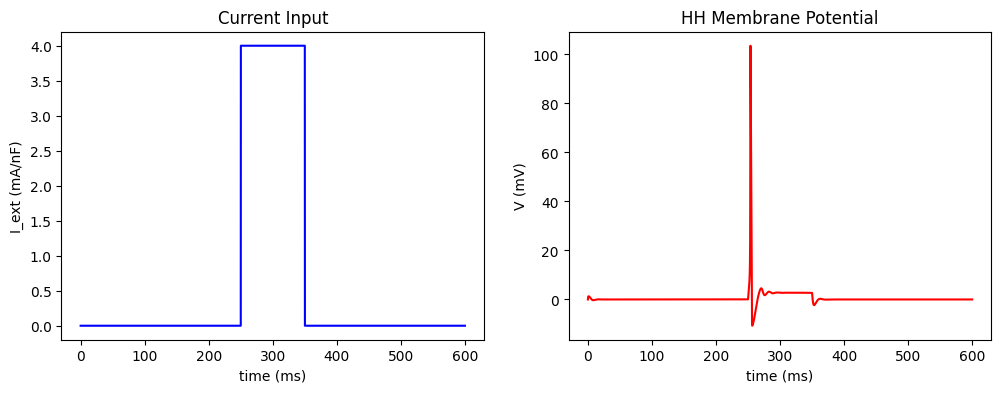

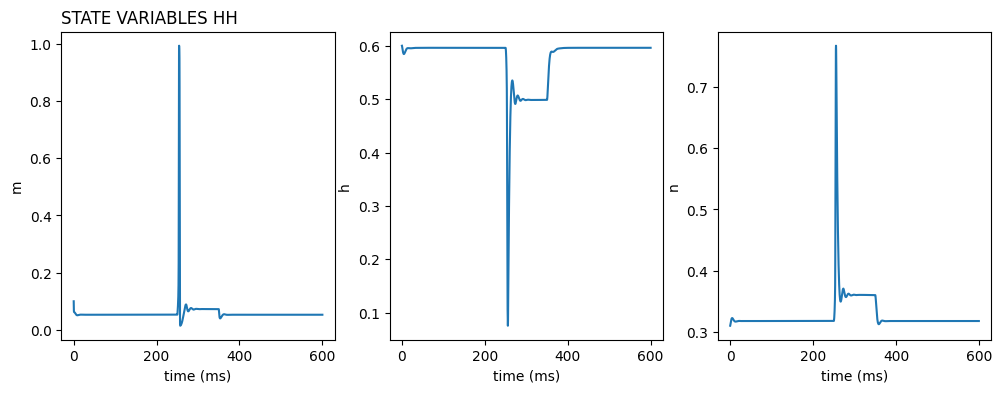

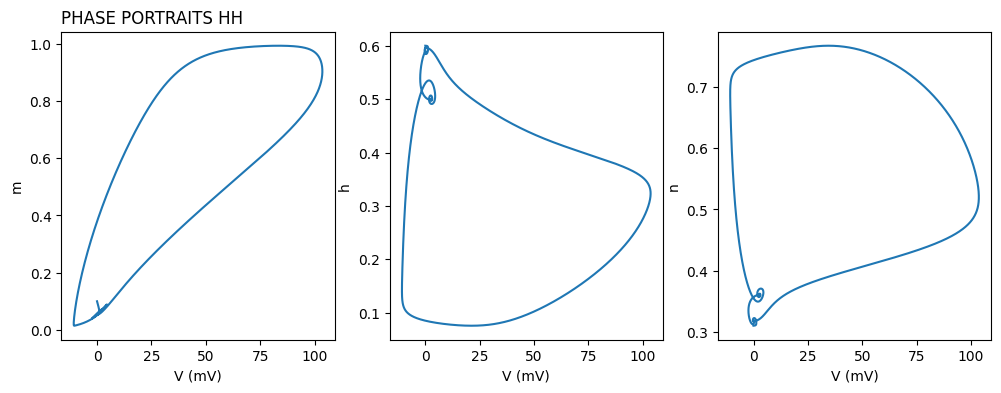

In [8]:
# Intial Values
m0, h0, n0, v0 = 0.1, 0.6, 0.31, 0

# Initialise the input current's desired parameters
pulse_duration = 100
amplitude_range = [0.1, 5]

steps_per_pulse = int(pulse_duration / dt) # Number of steps per pulse

# Generate a single pulse in the middle of the current waveform
start_index = num_steps // 2 - steps_per_pulse // 2
end_index = start_index + steps_per_pulse
# amplitude = np.random.uniform(amplitude_range[0], amplitude_range[1])
amplitude = 4
I_ext[start_index:end_index] = amplitude

m_values, h_values, n_values, v_values = simulate(num_steps, m0, h0, n0, v0, I_ext)
plot_sim(num_steps, dt, I_ext, m_values, h_values, n_values, v_values)

**Notes**



1.   The membrane potential increases with the input current, as described by the first ODE
2.   When the membrane potential reaches a certain threshold, a critical depolarization level is achieved. This triggers the opening of voltage-gated sodium channels, causing an influx of sodium ions (Na+) into the neuron. This influx of Na+ ions is shown in the plots for m and h.
3. The influx of Na+ ions further depolarizes the membrane potential, setting up a positive feedback loop. This leads to a rapid increase in the membrane potential, resulting in a spike or action potential.
4. During spike, potassium channels open, allowing potassium ions (K+) to leave the neuron which aids in repolarization.



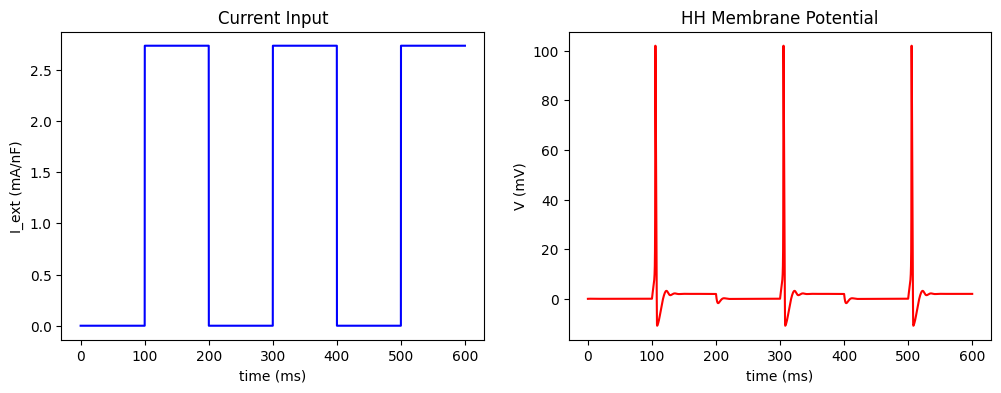

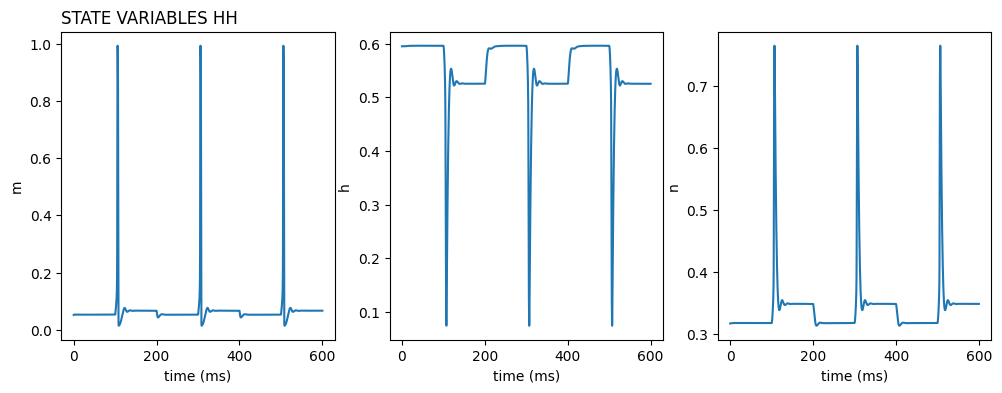

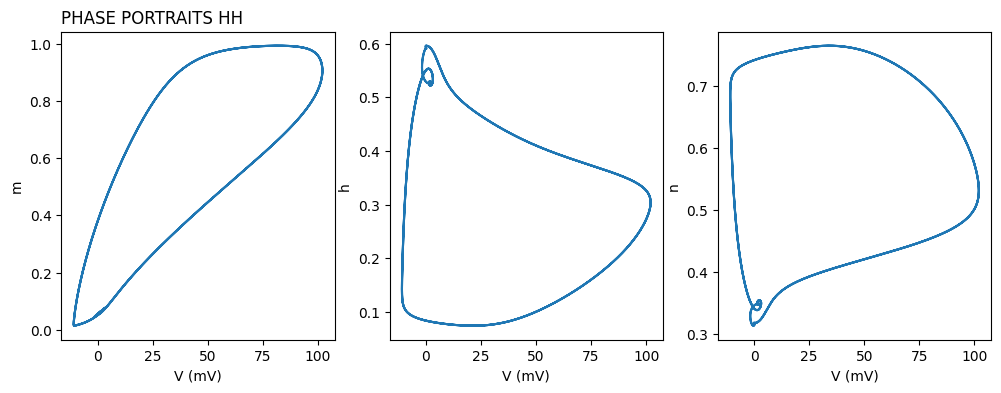

In [9]:
# Intial Values
m0, h0, n0, v0 = 0.052, 0.595, 0.317, 0

# Initialise the input current's desired parameters
pulse_duration = 100
amplitude_range = [0.1, 5]

steps_per_pulse = int(pulse_duration / dt) # Number of steps per pulse

# Generate pulses with uniform amplitude within the given range
const = np.random.uniform(amplitude_range[0], amplitude_range[1])
for i in range(0, num_steps, steps_per_pulse):
    if (i // steps_per_pulse) % 2 == 0:
        amplitude = 0
    else:
        amplitude = const
    I_ext[i:i+steps_per_pulse] = amplitude

m_values, h_values, n_values, v_values = simulate(num_steps, m0, h0, n0, v0, I_ext)
plot_sim(num_steps, dt, I_ext, m_values, h_values, n_values, v_values)

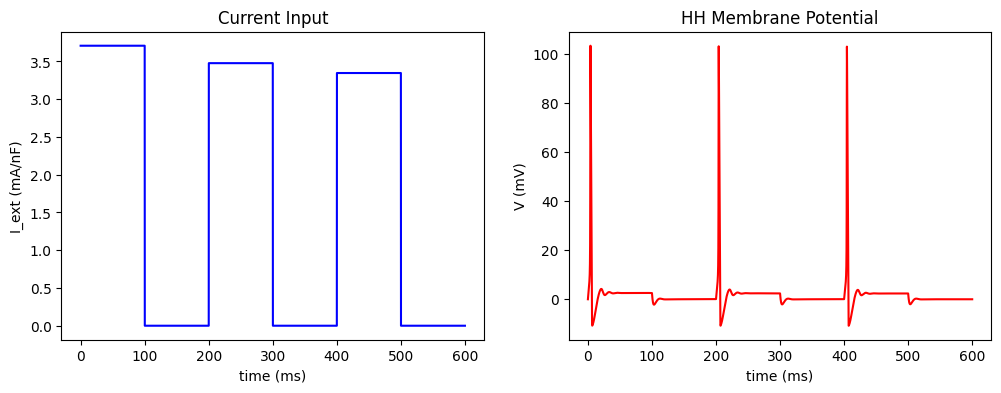

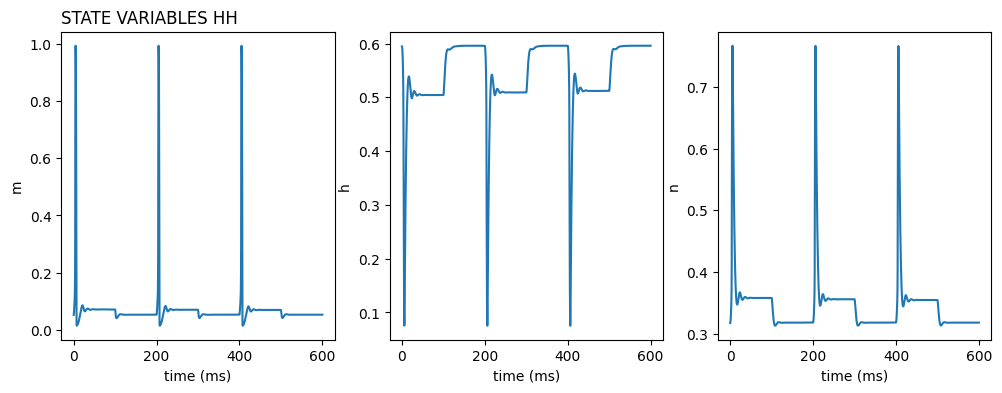

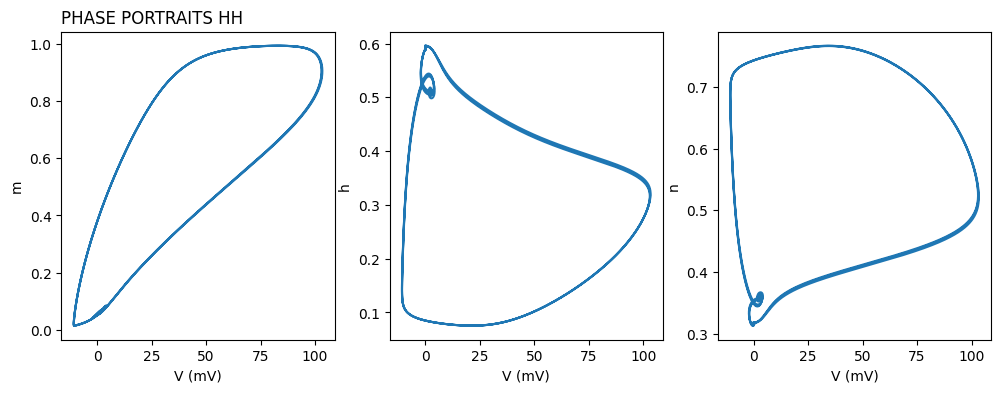

In [10]:
# Initialise the input current's desired parameters
pulse_duration = 100
amplitude_range = [0.1, 5]

steps_per_pulse = int(pulse_duration / dt) # Number of steps per pulse

# Generate pulses with random, alternating amplitudes within the given range
for i in range(0, num_steps, steps_per_pulse):
    if (i // steps_per_pulse) % 2 == 0:
        amplitude = np.random.uniform(amplitude_range[0], amplitude_range[1])
    else:
        amplitude = 0
    I_ext[i:i+steps_per_pulse] = amplitude

m_values, h_values, n_values, v_values = simulate(num_steps, m0, h0, n0, v0, I_ext)
plot_sim(num_steps, dt, I_ext, m_values, h_values, n_values, v_values)

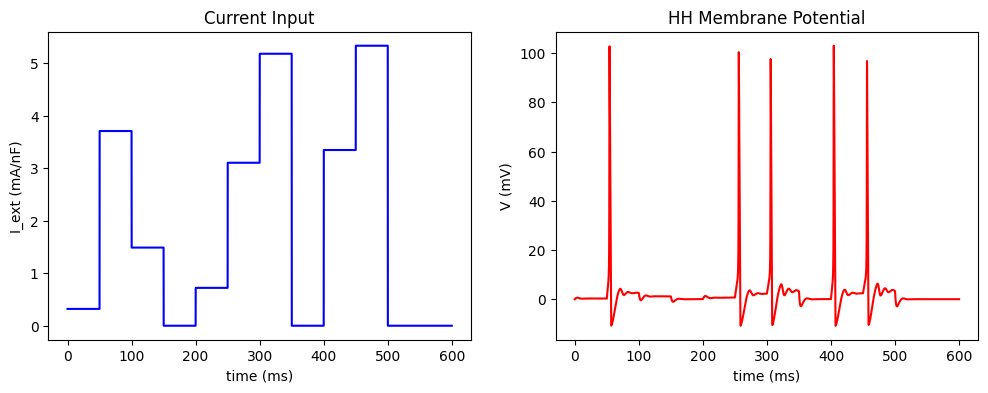

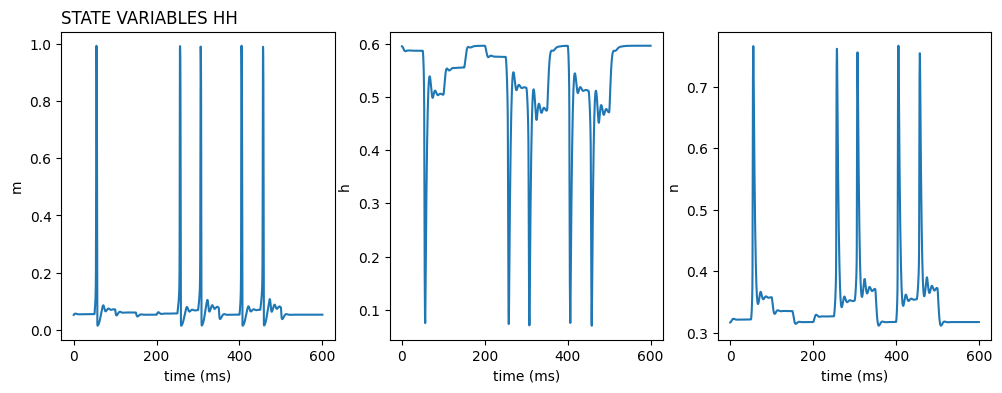

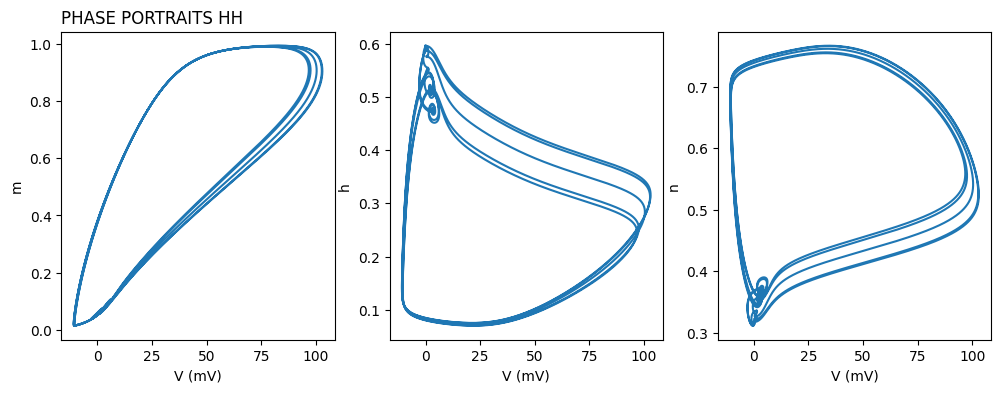

In [11]:
# Initialise the input current's desired parameters
pulse_duration = 50
amplitude_range = [0.1, 10]

steps_per_pulse = int(pulse_duration / dt) # Number of steps per pulse

# Generate a spike train with varying firing times/spacing

spike_probability = 0.4  # Adjust the firing probability

for i in range(0, num_steps, steps_per_pulse):
    if np.random.uniform() < spike_probability:
        amplitude = np.random.uniform(amplitude_range[0], amplitude_range[1])
        I_ext[i:i+steps_per_pulse] = amplitude

m_values, h_values, n_values, v_values = simulate(num_steps, m0, h0, n0, v0, I_ext)
plot_sim(num_steps, dt, I_ext, m_values, h_values, n_values, v_values)

**Note**

From the above tests, a couple of important things are clear:



1.   There is a current threshold that must be exceeded for an action potential to occur
2.   The spike occurs on the rising edge of the current waveform. Nothing happens on the falling edge
3. Input amplitude also seems to change the frequency of spikes


### Threshold and Action Potential Frequency Tests

The reason for walking you through the tests from the previous section was to suggest how you could build intuition through experiment. I would recommend reading around the subject, and delving through the resources in the ramp-up folder within the repository, but don't underestimate the familiarity you can develop through experimentation and trying to break the model.

In the following section, I will walk you through a more involved set of simulations used to find a firing threshold, and investigate the relationship between spiking frequency and input current amplitude. Try altering the simulations and coming up with your own conclusions.

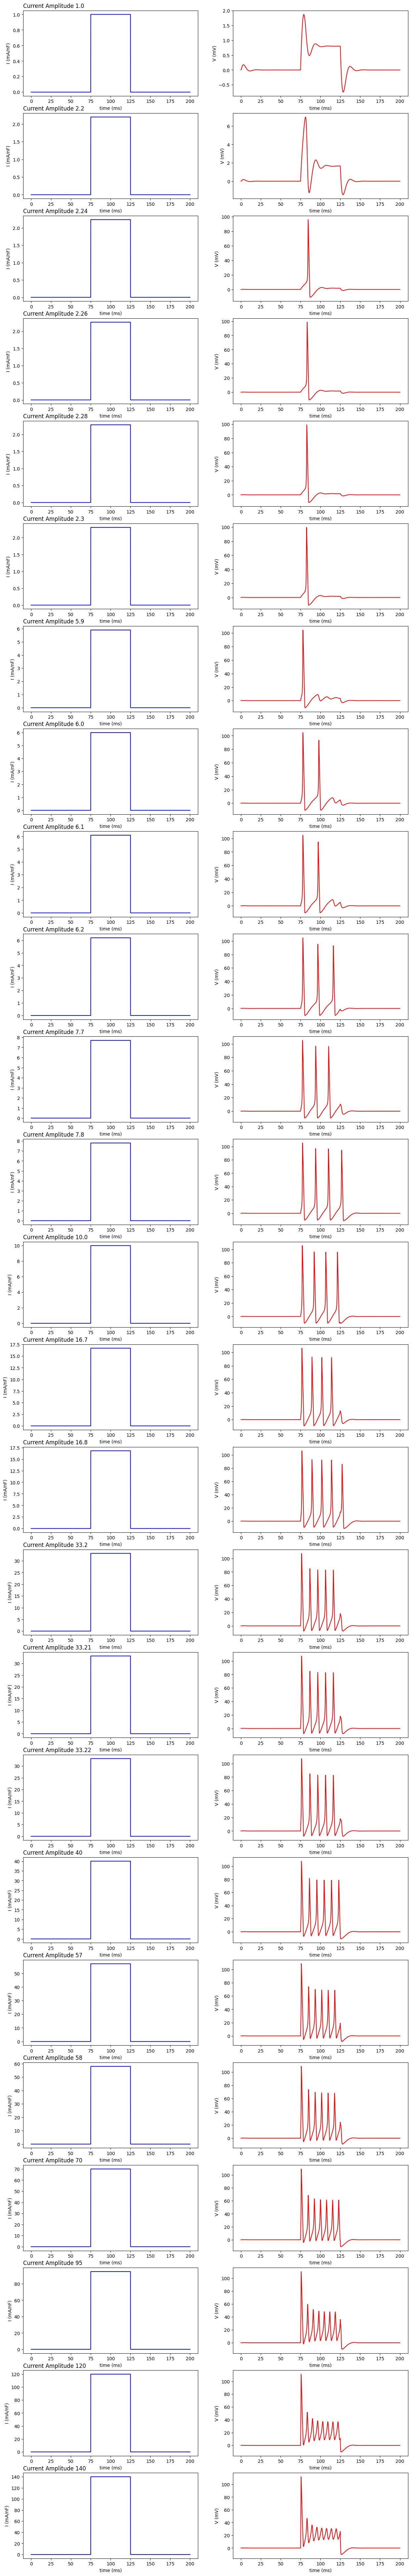

In [12]:
# Intial Values
dt = 0.01 # Time-step in ms
runtime = 200 # Desired simulation time in ms
num_steps = int(runtime/dt)

# Initialise the input current's desired parameters
pulse_duration = 50
steps_per_pulse = int(pulse_duration / dt) # Number of steps per pulse

test_amplitudes=[1.0, 2.2, 2.24, 2.26, 2.28, 2.3, 5.9, 6.0, 6.1, 6.2, 7.7, 7.8, 10.0, 16.7, 16.8, 33.2, 33.21, 33.22, 40, 57, 58, 70, 95, 120, 140]

time = np.arange(0, num_steps * dt, dt) # time array
fig, axes = plt.subplots(len(test_amplitudes), 2, figsize=(15, 100))
# Set x-axis label for all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.set_xlabel('time (ms)')

for i in range(1,len(test_amplitudes)+1):
  I_ext = np.zeros(num_steps)

  steps_per_pulse = int(pulse_duration / dt) # Number of steps per pulse
  # Generate a single pulse in the middle of the current waveform
  start_index = num_steps // 2 - steps_per_pulse // 2
  end_index = start_index + steps_per_pulse
  amplitude = test_amplitudes[i-1]
  I_ext[start_index:end_index] = amplitude

  m,h,n,v = simulate(num_steps, 0.05, 0.6, 0.315, 0.0, I_ext)

  # Plot on each subplot
  axes[i-1, 0].plot(time, I_ext, color='blue')
  axes[i-1, 0].set_xlabel('time (ms)')
  axes[i-1, 0].set_ylabel('I (mA/nF)')

  axes[i-1, 1].plot(time, v, color='red')
  axes[i-1, 1].set_xlabel('time (ms)')
  axes[i-1, 1].set_ylabel('V (mV)')

  # Set the title for the entire row
  axes[i-1, 0].set_title('Current Amplitude ' + str(amplitude), loc='left')

**Important**

The above suggests that the action potential threshold is around 2.26 mA/nF for a pulse of duration 50 ms. The increase in action potential frequency with respect to input current amplitude also seems to slow down with higher and higher amplitudes.

An increase in current amplitude leads to greater depolarisation, which means that the threshold for action potential generation can be reached more easily. This results in the increased firing frequency of action potentials. The continous nature of the freq. plot would suggest the neuron is type I as expected.

Now watch what happens with a step input with varying amplitudes. What can you conclude about the frequency of spiking vs input amplitude?

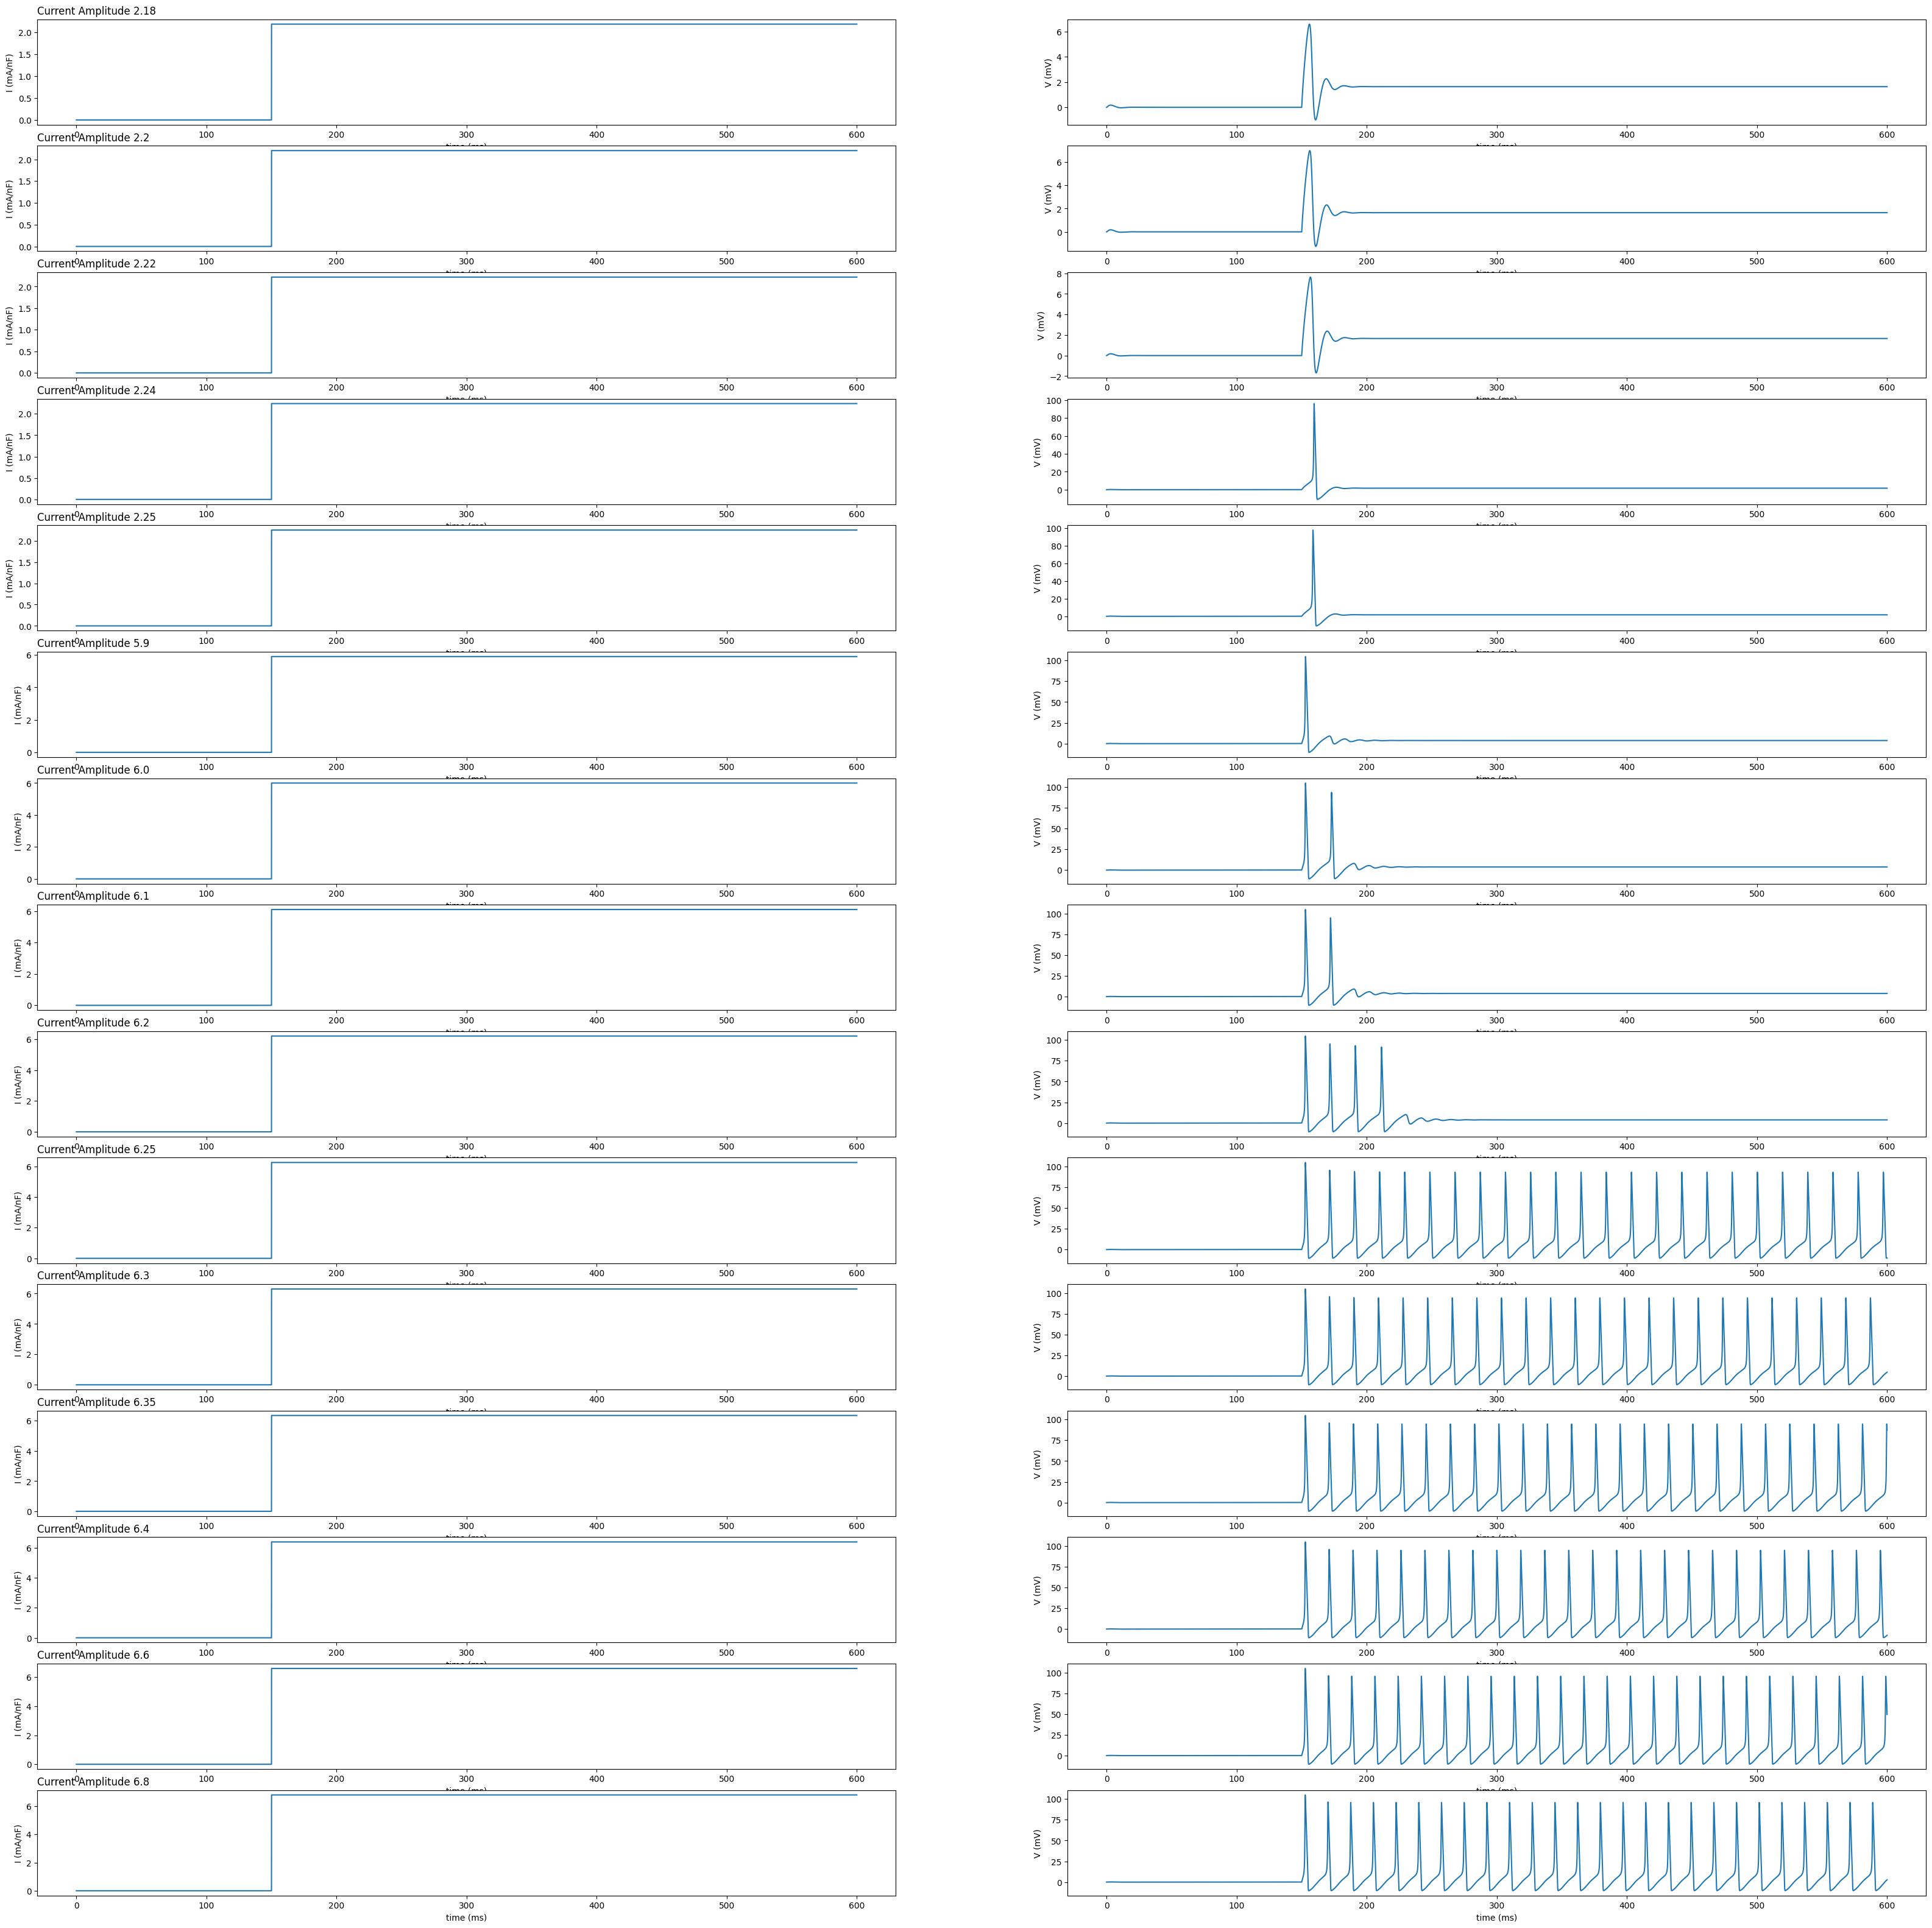

In [13]:
# Intial Values
dt = 0.01 # Time-step in ms
runtime = 600 # Desired simulation time in ms
num_steps = int(runtime/dt)

# Initialise the input current's desired parameters
pulse_duration = 150
steps_per_pulse = int(pulse_duration / dt) # Number of steps per pulse

test_amplitudes=[2.18,2.2,2.22,2.24,2.25,5.9,6.0,6.1,6.2,6.25,6.3,6.35,6.4,6.6,6.8]


time = np.arange(0, num_steps * dt, dt) # time array
fig, axes = plt.subplots(len(test_amplitudes), 2, figsize=(40, 40))
# Set x-axis label for all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.set_xlabel('time (ms)')

for i in range(1,len(test_amplitudes)+1):
  I_ext = np.zeros(num_steps)

  steps_per_pulse = int(pulse_duration / dt) # Number of steps per pulse
  start_index = num_steps // 4
  end_index = num_steps
  amplitude = test_amplitudes[i-1]
  I_ext[start_index:end_index] = amplitude

  m,h,n,v = simulate(num_steps, 0.05, 0.6, 0.315, 0.0, I_ext)

  # Plot on each subplot
  axes[i-1, 0].plot(time, I_ext)
  axes[i-1, 0].set_ylabel('I (mA/nF)')

  axes[i-1, 1].plot(time, v)
  axes[i-1, 1].set_ylabel('V (mV)')

  # Set the title for the entire row
  axes[i-1, 0].set_title('Current Amplitude ' + str(amplitude), loc='left')

### Refractoriness

Periodic square pulse input with variable period (T),
pulse width (p) and amplitude (I).

The purpose of the test below is to demonstrate refractoriness. This refers to a period of time during which the membrane is less responsive to further current stimulations.

As discussed before, during the rising phase of the membrane potential, the Na+ channels open (m increases) and allow the influx of sodium ions, causing depolarisation. At the same time, the inactivation variable (h) also increases, leading to the closure of sodium channels and preventing their reopening. This inactivation results in refractoriness, as it temporarily stops the sodium channels activating again.

The gating variables eventually return to their resting state, after which more action potentials can be stimulated.

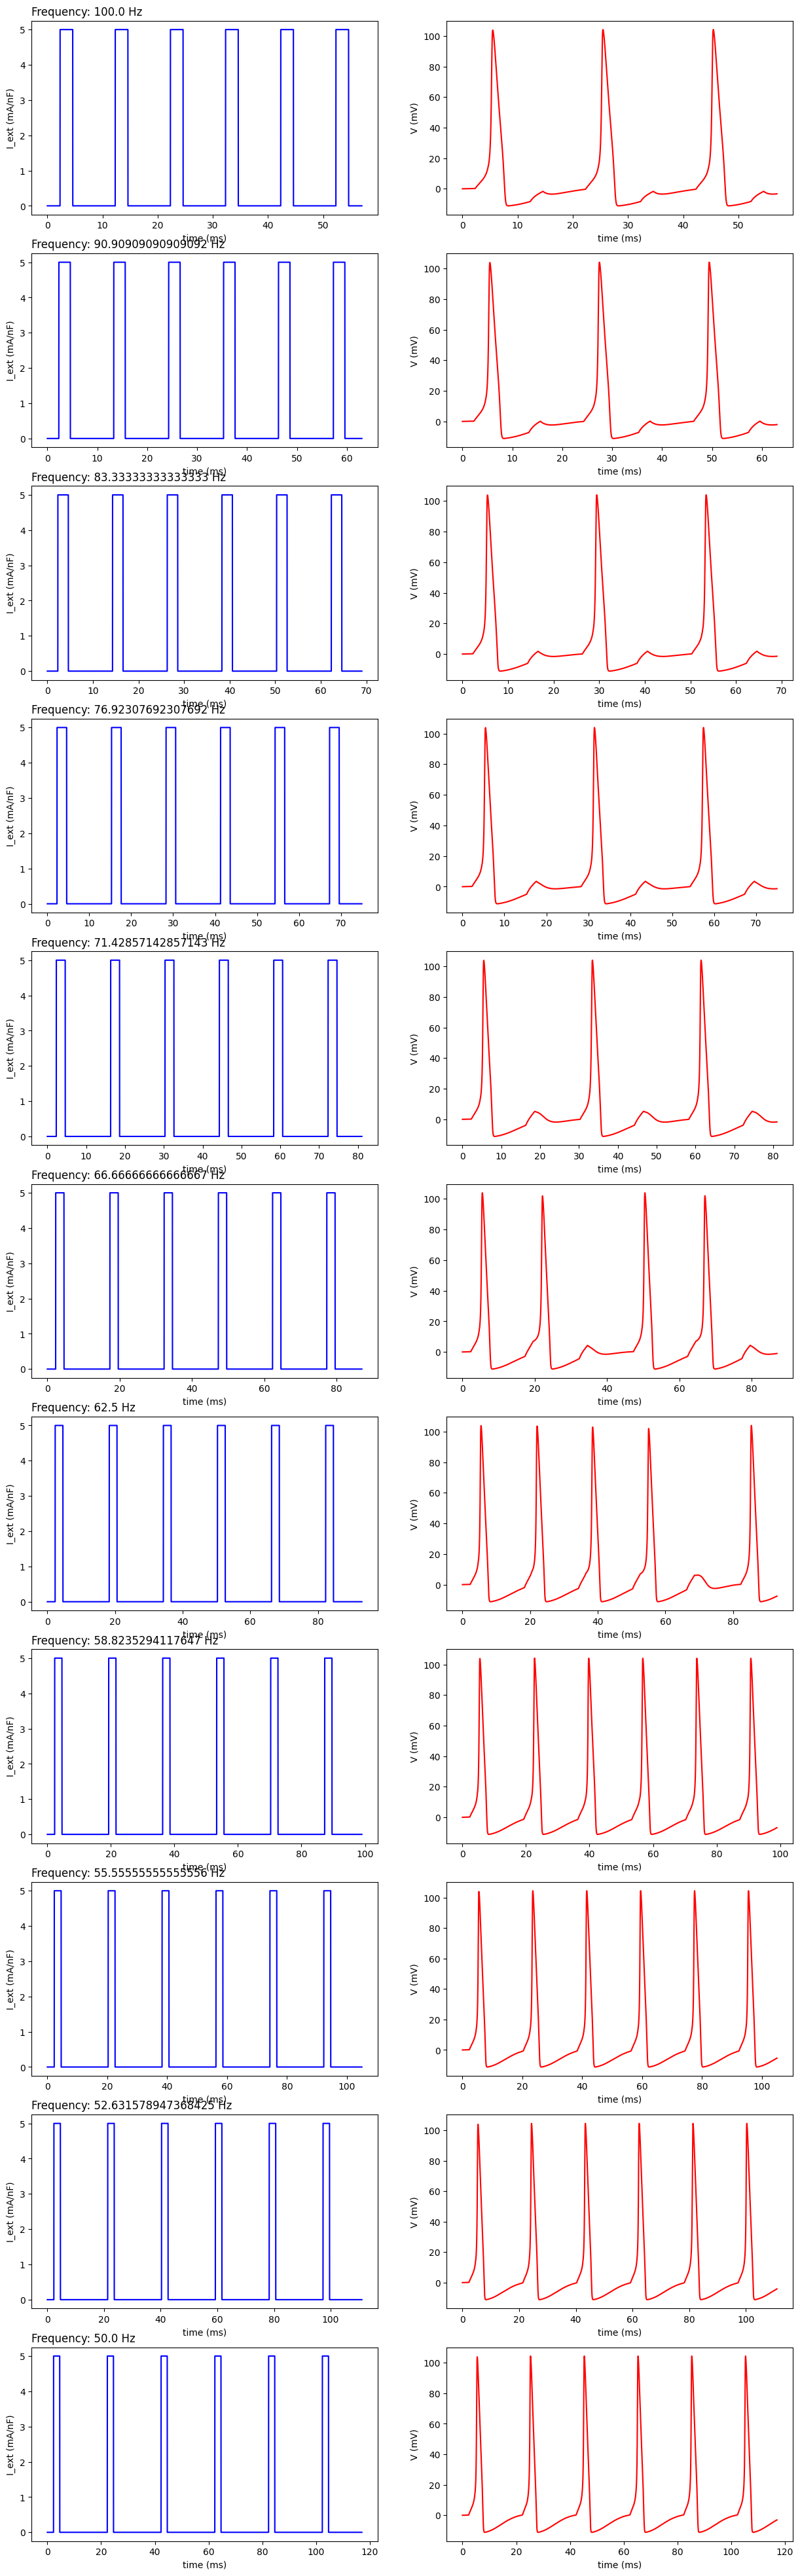

In [14]:
# Variables
T = [10,11,12,13,14,15,16,17,18,19,20]
p = 2.3
I = 5

fig, axes = plt.subplots(len(T), 2, figsize=(15, 50))
# Set x-axis label for all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.set_xlabel('time (ms)')

for i in range(0,len(T)):
  # 5 pulses:
  runtime = int(5*p + 6*(T[i]-p))

  #Intial conditions
  dt = 0.001 # Time-step in ms
  num_steps = int(runtime/dt)
  I_ext = np.zeros(num_steps) # Current initialised as zero amplitude

  # Generate the square pulse waveform
  spike_times = np.arange(p, runtime, T[i])  # Calculate the time steps for the pulses

  for spike_time in spike_times:
      start_step = int(spike_time / dt)  # Starting step index of the pulse
      end_step = int((spike_time + p) / dt)  # Ending step index of the pulse
      I_ext[start_step:end_step] = I  # Set the amplitude of the pulse

  time = np.arange(0, num_steps * dt, dt) # time array

  m,h,n,v = simulate(num_steps, 0.05, 0.6, 0.315, 0.0, I_ext)

  # Plot on each subplot
  axes[i, 0].plot(time, I_ext, color='blue')
  axes[i, 0].set_ylabel('I_ext (mA/nF)')

  axes[i, 1].plot(time, v, color='red')
  axes[i, 1].set_ylabel('V (mV)')

  # Set the title for the entire row

  axes[i, 0].set_title('Frequency: ' + str(1/(T[i]/1000)) + ' Hz', loc='left')

Now we take a look at stimulating the membrane with negative amplitudes.

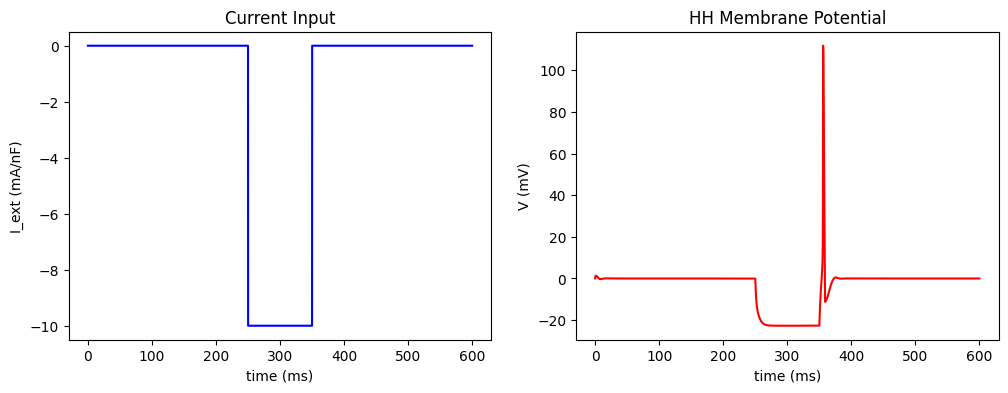

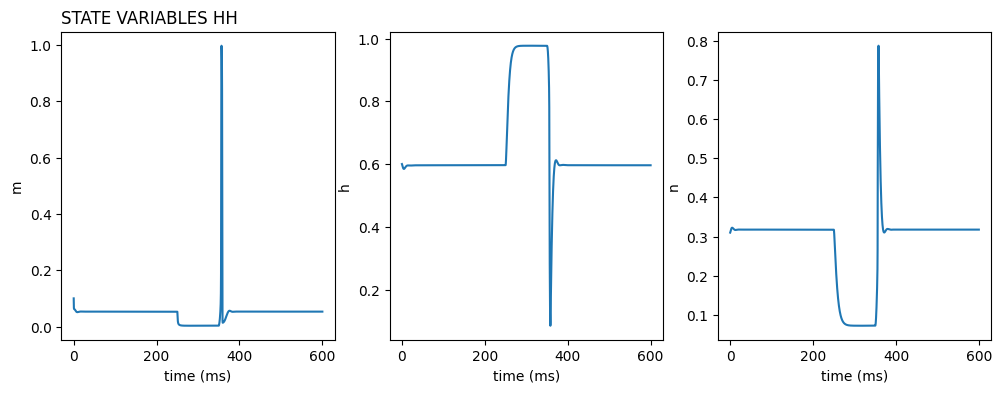

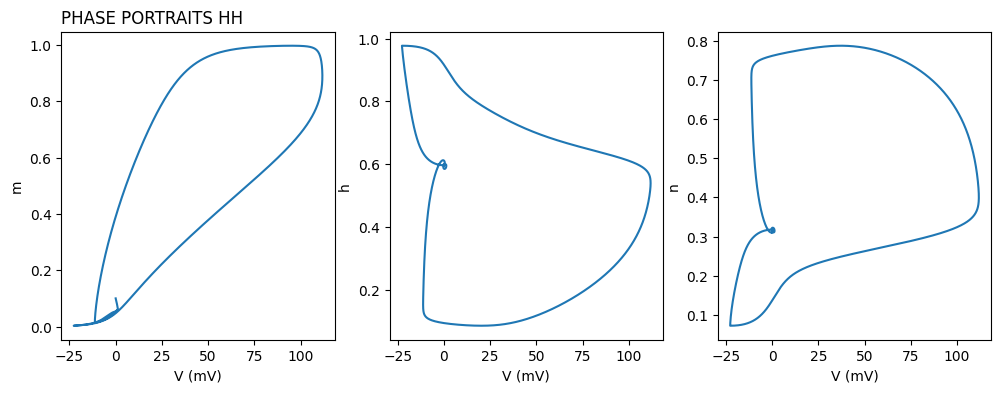

In [15]:
#Intial conditions for Integration

dt = 0.001 # Time-step in ms
runtime = 600 # Desired simulation time in ms
num_steps = int(runtime/dt)
I_ext = np.zeros(num_steps) # Current initialised as zero amplitude

# Initialise the input current's desired parameters
pulse_duration = 100
amplitude_range = [0.1, 5]

steps_per_pulse = int(pulse_duration / dt) # Number of steps per pulse

# Generate a single pulse in the middle of the current waveform
start_index = num_steps // 2 - steps_per_pulse // 2
end_index = start_index + steps_per_pulse
amplitude = -10
I_ext[start_index:end_index] = amplitude

m_values, h_values, n_values, v_values = simulate(num_steps, 0.1, 0.6, 0.31, 0, I_ext)
plot_sim(num_steps, dt, I_ext, m_values, h_values, n_values, v_values)

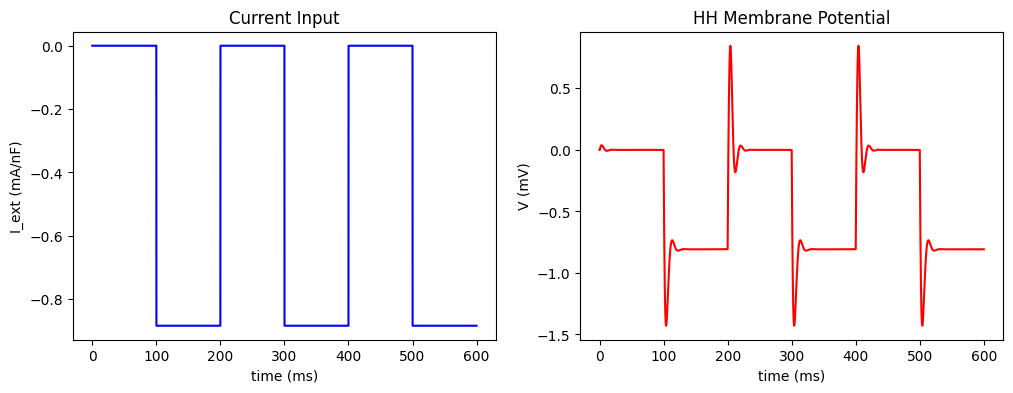

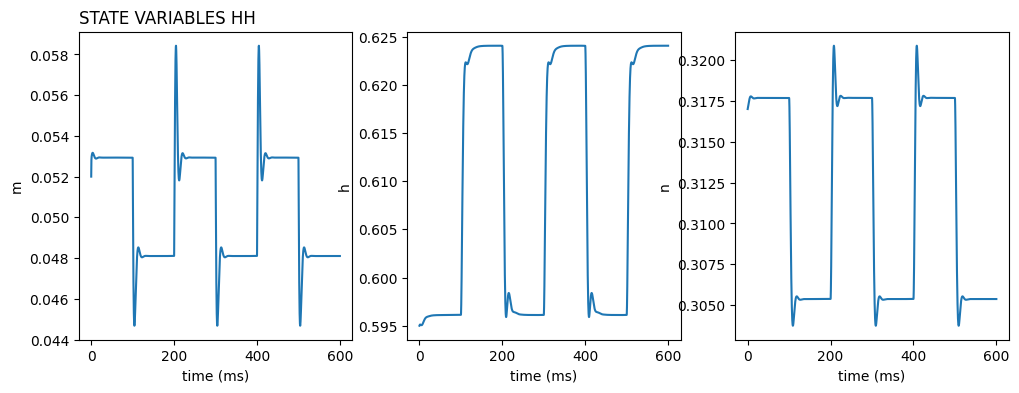

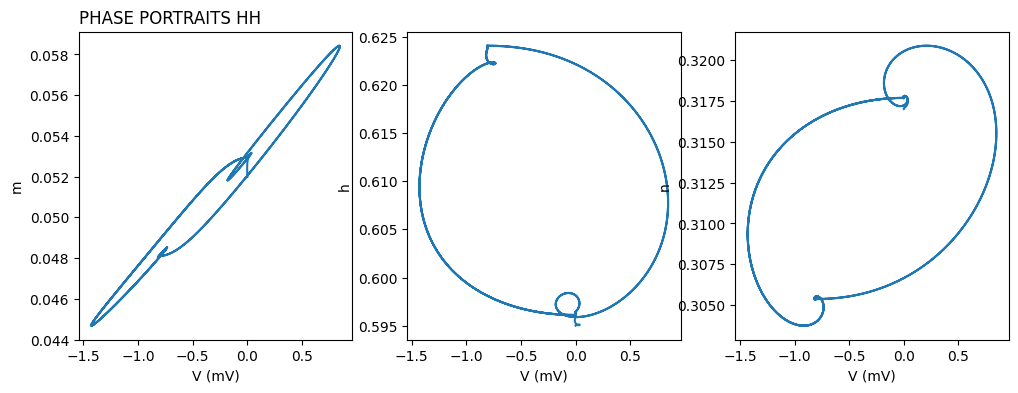

In [16]:
# Initialise the input current's desired parameters
pulse_duration = 100
amplitude_range = [-5, -0.1]

steps_per_pulse = int(pulse_duration / dt) # Number of steps per pulse

# Generate pulses with uniform amplitude within the given range
const = np.random.uniform(amplitude_range[0], amplitude_range[1])
for i in range(0, num_steps, steps_per_pulse):
    if (i // steps_per_pulse) % 2 == 0:
        amplitude = 0
    else:
        amplitude = const
    I_ext[i:i+steps_per_pulse] = amplitude

m_values, h_values, n_values, v_values = simulate(num_steps, 0.052, 0.595, 0.317, 0, I_ext)
plot_sim(num_steps, dt, I_ext, m_values, h_values, n_values, v_values)

**Observations**



1.   There's no negative threshold, so to speak. However, if you make the current too negative, no action potentials occur. So the negative current must be inhibiting the membrane and making it more difficult to reach the positive firing potential.
2.   There's no refractoriness?
3.   There's a period of time before the action potential, (triggered on the rising edge of the current), where the equilibrium potential of the membrane is lowered

**Note on Hyperpolarisation**

The equilibrium potential dropped because of hyperpolarisation: you're taking positive ionic current away, i.e. removing Na+, K+, thereby leaving a negative charge on the membrane. Hence, the potential drops.







## Multiquadratic Integrate-and-Fire Neuron

Hopefully, this notebook has helped you learn a bit more about the Hodgkin Huxley model. There are many dimensions of information that we would love to use for neuromorphic paradigms - the behaviour of the HH model is weird/selective by design! Unfortunately, it is difficult to mathematically analyse, and also very difficult to control and parametise.

Instead, we now come to the MQIF neuron model presented in the thesis written by Tomas Van Pottelbergh. Play around with it here - aim to build intuition and evaluate its efficacy in reflecting the informative behaviours of the HH model.

The rest of the notebook will be less guided, since it stands to serve as a sandbox for your exploration, (plus I am in a rush!).

Also check out the 'MQIF_Neuron_Python.py' file! It has been implemented specifically to guide you through the functionised version of this neuron. It also presents one method to track the number of spikes in a burst, which can be useful for characterising the behevaiour of the neuron.

### ODE's - MQIF

In [17]:
# ODE's

def Vs_dot(V, Vs, tau_s):
  return (V - Vs) / tau_s

def Vus_dot(V, Vus, tau_us):
  return (V - Vus) / tau_us

def V_dot(V, Vs, Vus, I_ext, # Current values
          V0, Vs0, Vus0, #Intial values
          g_f, g_s, g_us, # Conductances
          C): #Capacitance

  return (I_ext + g_f*((V-V0)**2) - g_s*((Vs-Vs0)**2) - g_us*((Vus-Vus0)**2)) / C

### Forwards Euler Integration

In [18]:
def simulate_MQIF(num_steps, dt, V0, Vs0, Vus0, I_ext,
                  V_threshold=20, V_reset=-45, Vs_reset=7.5, delta_Vus=1.7,
                  g_f = 1.0, g_s = 0.5, g_us = 0.015,
                  tau_s = 4.3, tau_us = 278,
                  C = 0.82):

  # Initialize arrays to store results
  V_values = np.zeros(num_steps)
  V_values[0] = V0

  Vs_values = np.zeros(num_steps)
  Vs_values[0] = Vs0

  Vus_values = np.zeros(num_steps)
  Vus_values[0] = Vus0

  # Initialize arrays to store derivatives for phase plots
  Vdot_values = np.zeros(num_steps)
  Vsdot_values = np.zeros(num_steps)
  Vusdot_values = np.zeros(num_steps)

  # Perform forward Euler integration
  for i in range(0, num_steps-1):

      # Set current value
      V_i, Vs_i, Vus_i = V_values[i], Vs_values[i], Vus_values[i]
      I_i = I_ext[i]

      # Update step
      Vs_new = Vs_i + dt * Vs_dot(V_i, Vs_i, tau_s)
      Vus_new = Vus_i + dt * Vus_dot(V_i, Vus_i, tau_us)

      V_new = V_i + dt * V_dot(V_i, Vs_i, Vus_i, I_i,
                               V0, Vs0, Vus0,
                               g_f, g_s, g_us,
                               C)

      Vdot_values[i] = V_dot(V_i, Vs_i, Vus_i, I_i,
                               V0, Vs0, Vus0,
                               g_f, g_s, g_us,
                               C)
      Vsdot_values[i] = Vs_dot(V_i, Vs_i, tau_s)
      Vusdot_values[i] = Vus_dot(V_i, Vus_i, tau_us)

      # Update array
      if V_new > V_threshold:
        V_values[i+1] = V_reset
        Vs_values[i+1] = Vs_reset
        Vus_values[i+1] = Vus_new + delta_Vus

      else:
        V_values[i+1] = V_new
        Vs_values[i+1] = Vs_new
        Vus_values[i+1] = Vus_new

  return V_values, Vs_values, Vus_values, Vdot_values, Vsdot_values, Vusdot_values

In [19]:
def plot_MQIF(num_steps, dt, I_ext, V, Vs, Vus, Vdot, Vsdot, Vusdot, state_variables=True, phase_portrait=True):
  time = np.arange(0, num_steps * dt, dt)

  fig1, axes = plt.subplots(1, 2, figsize=(12,4))

  axes[0].plot(time, I_ext, color='blue')
  axes[0].set_title('Current Input')
  axes[0].set_xlabel('time (ms)')
  axes[0].set_ylabel('I_ext (mA/nF)')

  axes[1].plot(time, V, color='crimson')
  axes[1].set_title('MQIF Membrane Potential')
  axes[1].set_xlabel('time (ms)')
  axes[1].set_ylabel('V (mV)')

  if state_variables:
    fig2, axes = plt.subplots(1, 2, figsize=(8,3))

    axes[0].plot(time, Vs, color='mediumorchid')
    axes[0].set_xlabel('time (ms)')
    axes[0].set_ylabel('Vs (mV)')

    axes[1].plot(time, Vus, color='mediumorchid')
    axes[1].set_xlabel('time (ms)')
    axes[1].set_ylabel('Vus (mV)')

    axes[0].set_title('STATE VARIABLES MQIF', loc='left')

  if phase_portrait:
    fig3, axes = plt.subplots(1, 2, figsize=(8,3))

    axes[0].plot(V, Vs, color='mediumorchid')
    axes[0].set_xlabel('V (mV)')
    axes[0].set_ylabel('Vs (mV)')

    axes[1].plot(V, Vus, color='mediumorchid')
    axes[1].set_xlabel('V (mV)')
    axes[1].set_ylabel('Vus (mV)')

    axes[0].set_title('PHASE PORTRAITS MQIF', loc='left')

    fig4, axes = plt.subplots(1, 3, figsize=(20,4))

    axes[0].plot(V, Vdot, color='blueviolet')
    axes[0].set_xlabel('V (mV)')
    axes[0].set_ylabel('V_dot (mV/ms)')

    axes[1].plot(V, Vsdot, color='blueviolet')
    axes[1].set_xlabel('V (mV)')
    axes[1].set_ylabel('Vs_dot (mV/ms)')

    axes[2].plot(V, Vusdot, color='blueviolet')
    axes[2].set_xlabel('V (mV)')
    axes[2].set_ylabel('Vus_dot (mV/ms)')

    axes[0].set_title('PHASE PORTRAITS MQIF', loc='left')

### Tests

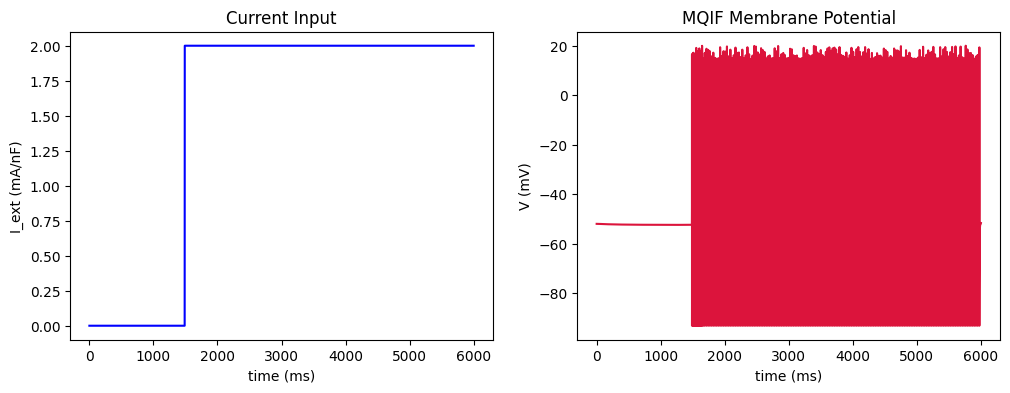

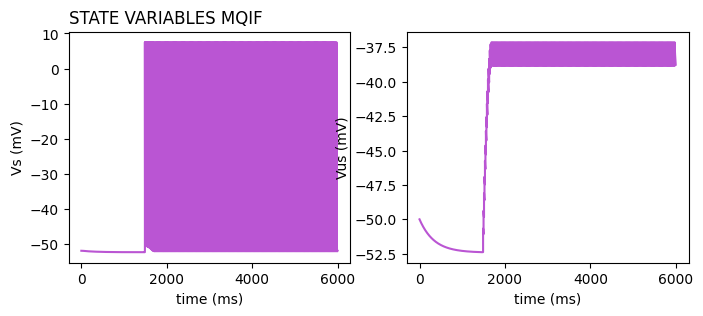

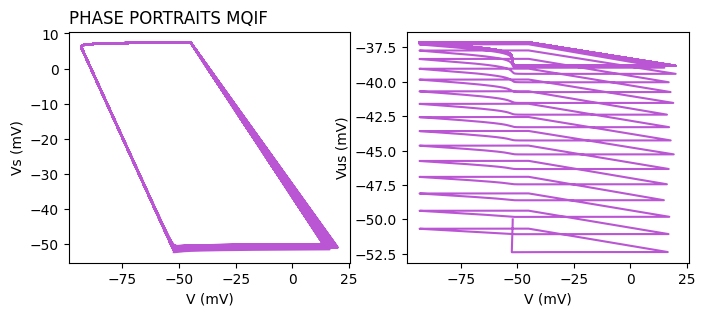

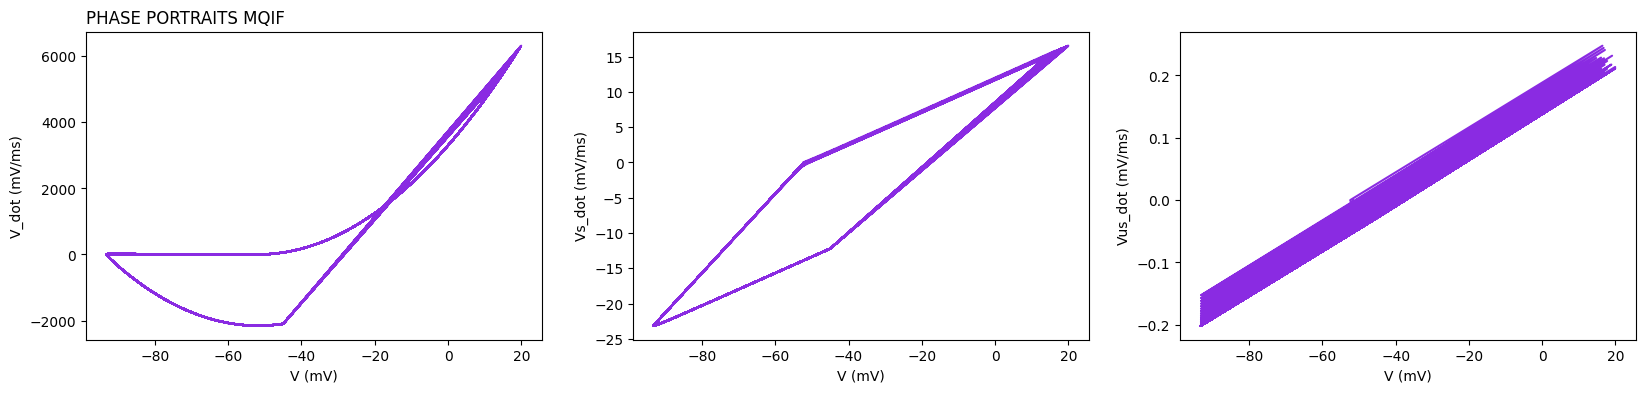

In [23]:
V0, Vs0, Vus0 = -52, -52, -50

#Intial conditions for Integration

dt = 0.001 # Time-step in ms
runtime = 6000 # Desired simulation time in ms
num_steps = int(runtime/dt)
I_ext = np.zeros(num_steps) # Current initialised as zero amplitude

# Initialise the input current's desired parameters
pulse_duration = 50
amplitude_range = [0.1, 5]

steps_per_pulse = int(pulse_duration / dt) # Number of steps per pulse

# Generate a single pulse in the middle of the current waveform
start_index = num_steps // 4 - steps_per_pulse // 4
end_index = start_index + steps_per_pulse
# amplitude = np.random.uniform(amplitude_range[0], amplitude_range[1])
amplitude = 2
# I_ext[start_index:end_index] = amplitude
I_ext[start_index:] = amplitude

V_values, Vs_values, Vus_values, Vdot_values, Vsdot_values, Vusdot_values = simulate_MQIF(num_steps, dt, V0, Vs0, Vus0, I_ext)
plot_MQIF(num_steps, dt, I_ext, V_values, Vs_values, Vus_values, Vdot_values, Vsdot_values, Vusdot_values)